<a href="https://colab.research.google.com/github/parsa-abbasi/Sentiment-Analysis/blob/master/Multiclass-Classification/DL_FastTextEmb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

## Install required libraries

In [1]:
!pip install matplotlib==3.1.0

  Using cached matplotlib-3.1.0.tar.gz (37.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for matplotlib
Failed to build matplotlib
  Running setup.py install for matplotlib: started
  Running setup.py install for matplotlib: finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [505 lines of output]
      Edit setup.cfg to change the build options
      
      BUILDING MATPLOTLIB
        matplotlib: yes [3.1.0]
            python: yes [3.8.0 (tags/v3.8.0:fa919fd, Oct 14 2019, 19:37:50) [MSC
                        v.1916 64 bit (AMD64)]]
          platform: yes [win32]
      
      OPTIONAL SUBPACKAGES
       sample_data: yes [installing]
             tests: no  [skipping due to configuration]
      
      OPTIONAL BACKEND EXTENSIONS
               agg: yes [installing]
             tkagg: yes [installing; run-time loading from Python Tcl/Tk]
            macosx: no  [Mac OS-X only]
      
      OPTIONAL PACKAGE DATA
              dlls: no  [skipping due to configuration]
      
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-3.8
      copying lib\pylab.py -> build

In [2]:
!pip install hazm
!pip install stopwords_guilannlp

## Get FastText

Download FastText word vectors file for Persian

(The list of all model vector files are available [here](https://fasttext.cc/docs/en/pretrained-vectors.html))

In [3]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fa.vec

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Import Libraries

In [27]:
!pip install gensim

You should consider upgrading via the 'H:\vafatech\Code\Sentiment-Analysis\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [7]:
# General
import numpy as np
import pandas as pd
import codecs
#from google.colab import files
# Word Embedding
from gensim.models import KeyedVectors
# Keras
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding, Dropout
from keras.layers import GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.utils.np_utils import to_categorical
from keras.metrics import categorical_accuracy
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

# Preprocessing
from stopwords_guilannlp import stopwords_output
from hazm import *
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import plot_model
# Measuring metrics
from sklearn.metrics import f1_score

# Upload dataset files

Upload dataset files to colab environment

In [6]:
#uploaded = files.upload()


# Import & Analyze Dataset

In [8]:
test = pd.read_csv('test.csv', index_col=None, header=None, encoding="utf-8")

In [9]:
x_test = test[0]
y_test = test[1]

In [10]:
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of testing sentence:  (1854,)
Number of testing label:  (1854,)


In [11]:
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [12]:
original = pd.read_csv('original.csv', index_col=None, header=None, encoding="utf-8")
balanced = pd.read_csv('balanced.csv', index_col=None, header=None, encoding="utf-8")
translation = pd.read_csv('translation.csv', index_col=None, header=None, encoding="utf-8")

In [13]:
selected_dataset = original

In [14]:
selected_dataset = selected_dataset.sample(frac=1).reset_index(drop=True)

In [15]:
x_train = selected_dataset[0]
y_train = selected_dataset[1]

In [16]:
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)

Number of training sentence:  (5561,)
Number of training label:  (5561,)


In [17]:
# Convert dataframes to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [18]:
# See the data number of sentence in each category 
from collections import Counter
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

{1: 1623, 0: 2409, 2: 988, -1: 513, -2: 28}


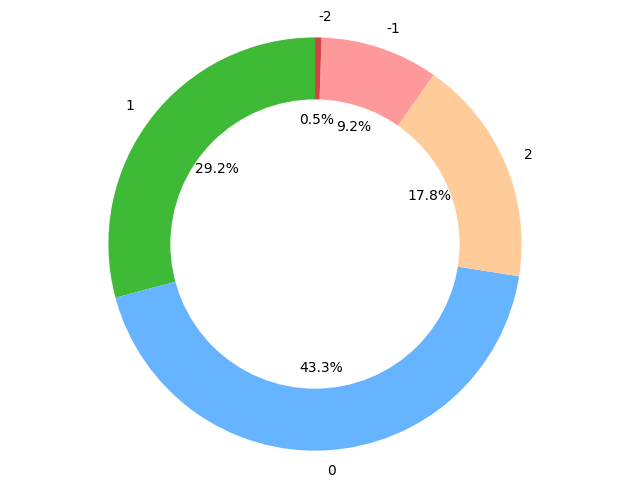

In [19]:
import matplotlib.pyplot as plt
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('distribution.png')
plt.show()

In [ ]:
# Decomment following line if you want to download dataset figure
# files.download('distribution.png')

# Preprocess

In [20]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)
    # tokens = [w for w in tokens if not w in stop_set]    # Remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = ' '.join(tokens)
    return tokens

# Prepare FastText Model

In [27]:
EMBEDDING_FILE = 'wiki.fa.vec'

ft_model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE)


In [36]:
EMBEDDING_FILE = 'wiki.fa.vec'

def import_with_gensim(file_address):
  # Creating the model
  ft_model = KeyedVectors.load_word2vec_format(file_address)
  # Getting the tokens
  ft_words = []

  #for ft_word in ft_model.vocab:
  for ft_word in ft_model.key_to_index: #-- gensim 3.x to gensim 4.00 (Hamid)

      ft_words.append(ft_word)
  return ft_model, ft_words
  
ft_model, ft_words = import_with_gensim(EMBEDDING_FILE)

In [37]:
# FastText embedding dimensionality
embed_size = 300

In [38]:
# We get the mean and standard deviation of the embedding weights so that we could maintain the
# same statistics for the rest of our own random generated weights.
embedding_list = list()
for w in ft_words:
  embedding_list.append(ft_model[w])

all_embedding = np.stack(embedding_list)
emb_mean, emb_std = all_embedding.mean(), all_embedding.std()

# Prepare data for Deep Learning model

## Apply preprocessing to data

In [39]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

In [40]:
# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

## Setting tokenizer up

In [41]:
num_words = 2000

# Create the tokenizer
tokenizer = Tokenizer(num_words=num_words)

# fFt the tokenizer on the training documents
tokenizer.fit_on_texts(train_docs)

In [42]:
# Find maximum length of training sentences
max_length = max([len(s.split()) for s in train_docs])

## Embed sentences

In [43]:
# Embed training sequences
encoded_docs = tokenizer.texts_to_sequences(train_docs)

# Pad embeded training sequences
x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [44]:
# Define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index)

In [46]:
# We are going to set the embedding size to the pre-trained dimension as we are replicating it
nb_words = len(tokenizer.word_index)

# the size will be Number of Words in Vocab X Embedding Size
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

# With the newly created embedding matrix, we'll fill it up with the words that we have in both
# our own dictionary and loaded pre-trained embedding.
embeddedCount = 0
for word, i in tokenizer.word_index.items():
    i -= 1
    # then we see if this word is in glove's dictionary, if yes, get the corresponding weights
    if word in ft_model.key_to_index:
        embedding_vector = ft_model[word]
        # and store inside the embedding matrix that we will train later on.
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
    else:   # Unknown words
        embedding_vector = ft_model['subdivision_name']
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1

print('total embedded:', embeddedCount, 'common words')
print('Embedding matrix shape:', embedding_matrix.shape)

total embedded: 6975 common words
Embedding matrix shape: (6975, 300)


In [47]:
# Embed testing sequences
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# Pad testing sequences
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# Deep Learning Models

In [48]:
# Prepare labels for categorical prediction
categorical_y_train = to_categorical(y_train, 5)
categorical_y_test = to_categorical(y_test, 5)

## B-LSTM Model

In [60]:
model_blstm = Sequential()
model_blstm.add(Embedding(vocab_size, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=True))
#model_blstm.add(Bidirectional(CuDNNLSTM(300, return_sequences=True, name='lstm_layer'))) #when using GPU
model_blstm.add(Bidirectional(LSTM(int(300/2), activation='tanh', return_sequences=True), merge_mode='concat')) # when using CPU
model_blstm.add(GlobalMaxPool1D())
model_blstm.add(Dropout(0.2))
model_blstm.add(Dense(300, activation="relu"))
model_blstm.add(Dropout(0.1))
model_blstm.add(Dense(5, activation='softmax'))

In [61]:
model_blstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_blstm.summary()
batch_size_blstm = 64
epochs_blstm = 5

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         2092500   
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 300)        541200    
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_4 (Dense)             (None, 300)               90300     
                                                                 
 dropout_5 (Dropout)         (None, 300)              

In [62]:

hist_blstm = model_blstm.fit(x_train_padded, categorical_y_train, batch_size=batch_size_blstm, epochs=epochs_blstm, shuffle=True)

Epoch 1/5
87/87 [==============================] - 411s 5s/step - loss: 1.2459 - categorical_accuracy: 0.4416
Epoch 2/5
87/87 [==============================] - 376s 4s/step - loss: 0.9561 - categorical_accuracy: 0.6033
Epoch 3/5
87/87 [==============================] - 417s 5s/step - loss: 0.7764 - categorical_accuracy: 0.6938
Epoch 4/5
87/87 [==============================] - 424s 5s/step - loss: 0.6434 - categorical_accuracy: 0.7522
Epoch 5/5
87/87 [==============================] - 425s 5s/step - loss: 0.5221 - categorical_accuracy: 0.8067


In [64]:
model_blstm.save_weights('model_blstm_weights.h5')
# Evaluate model
loss_blstm, acc_blstm = model_blstm.evaluate(x_test_padded, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_blstm*100))

Test Accuracy: 65.426105


In [67]:
# Get prediction label
#y_pred_blstm = model_blstm.predict_classes(x_test_padded) #This function were removed in TensorFlow version 2.6
predict_x=model_blstm.predict(x_test_padded) 
y_pred_blstm=np.argmax(predict_x,axis=1)

58/58 [==============================] - 31s 514ms/step


## CNN Model

In [73]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=True))
model_cnn.add(Conv1D(filters=64, kernel_size=4, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=16, activation='relu', padding='same'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(500, activation="sigmoid"))
model_cnn.add(Dense(5, activation='softmax'))

In [74]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_cnn.summary()
batch_size_cnn = 64
epochs_cnn = 8

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 300)         2092500   
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          76864     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 64)          32832     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, None, 64)         

In [75]:
# Train model
hist_cnn = model_cnn.fit(x_train_padded, categorical_y_train, batch_size=batch_size_cnn, epochs=epochs_cnn, shuffle=True)

Epoch 1/8
87/87 [==============================] - 36s 386ms/step - loss: 1.2904 - categorical_accuracy: 0.4211
Epoch 2/8
87/87 [==============================] - 35s 405ms/step - loss: 1.2313 - categorical_accuracy: 0.4742
Epoch 3/8
87/87 [==============================] - 39s 451ms/step - loss: 0.9281 - categorical_accuracy: 0.6515
Epoch 4/8
87/87 [==============================] - 37s 429ms/step - loss: 0.7077 - categorical_accuracy: 0.7421
Epoch 5/8
87/87 [==============================] - 38s 440ms/step - loss: 0.5363 - categorical_accuracy: 0.8146
Epoch 6/8
87/87 [==============================] - 40s 454ms/step - loss: 0.3715 - categorical_accuracy: 0.8729
Epoch 7/8
87/87 [==============================] - 39s 453ms/step - loss: 0.2438 - categorical_accuracy: 0.9259
Epoch 8/8
87/87 [==============================] - 41s 466ms/step - loss: 0.1616 - categorical_accuracy: 0.9531


In [76]:
model_cnn.save_weights('model_cnn_weights.h5')

# Evaluate model
loss_cnn, acc_cnn = model_cnn.evaluate(x_test_padded, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_cnn*100))

Test Accuracy: 60.787487


In [77]:
# Get prediction label
#y_pred_cnn = model_cnn.predict_classes(x_test_padded)
predict_x_cnn = model_cnn.predict(x_test_padded) 
y_pred_cnn=np.argmax(predict_x_cnn,axis=1)

58/58 [==============================] - 3s 43ms/step


# Confusion Matrix

In [78]:
y_test_label = []
for counter in range(0, len(categorical_y_test)):
  label = np.argmax(categorical_y_test[:][counter])
  y_test_label.append(label)
y_test_label = np.array(y_test_label)

In [79]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array([0, 1, 2, -2, -1])
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[625 109   2   0   7]
 [169 359  25   0   8]
 [ 19 121 214   0   0]
 [  5   1   3   0   3]
 [107  61   1   0  15]]
AxesImage(size=(5, 5))
Normalized confusion matrix
[[0.84 0.15 0.   0.   0.01]
 [0.3  0.64 0.04 0.   0.01]
 [0.05 0.34 0.6  0.   0.  ]
 [0.42 0.08 0.25 0.   0.25]
 [0.58 0.33 0.01 0.   0.08]]
AxesImage(size=(5, 5))


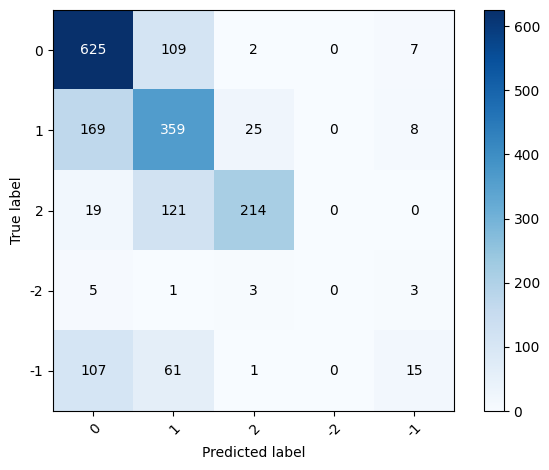

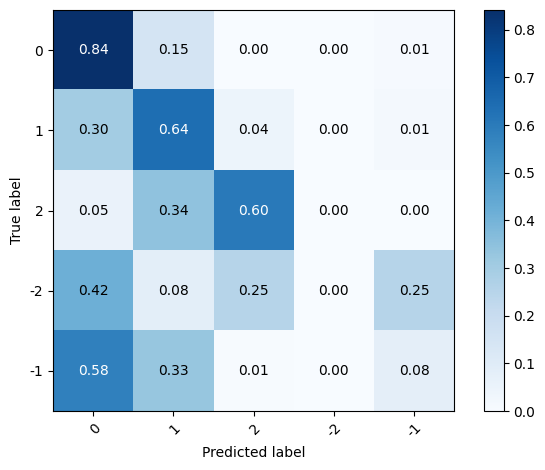

In [71]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_blstm, classes=class_names)
# plt.savefig('cm-blstm.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_blstm, classes=class_names, normalize=True)
# plt.savefig('cm-blstm-normalized.png')
plt.show()

Confusion matrix, without normalization
[[524  82  11   0 126]
 [118 270  75   0  98]
 [ 10  59 267   0  18]
 [  3   0   3   0   6]
 [ 71  36  11   0  66]]
AxesImage(size=(5, 5))
Normalized confusion matrix
[[0.71 0.11 0.01 0.   0.17]
 [0.21 0.48 0.13 0.   0.17]
 [0.03 0.17 0.75 0.   0.05]
 [0.25 0.   0.25 0.   0.5 ]
 [0.39 0.2  0.06 0.   0.36]]
AxesImage(size=(5, 5))


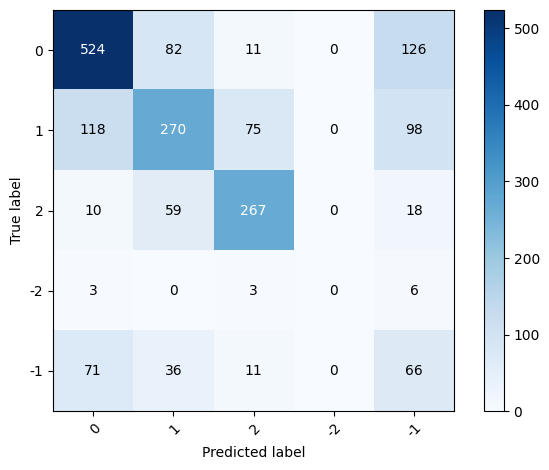

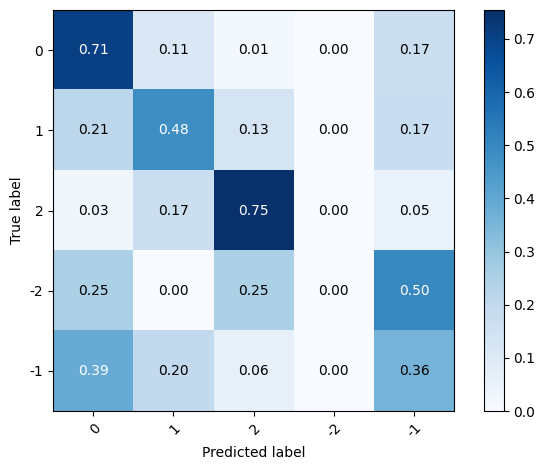

In [80]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_cnn, classes=class_names)
# plt.savefig('cm-cnn.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_cnn, classes=class_names, normalize=True)
# plt.savefig('cm-cnn-normalized.png')
plt.show()

## F1 Score

In [81]:
print("(Weighted) F1 score of FastTextEmb B-LSTM model:")
f1_score(y_test_label, y_pred_blstm, average='weighted')

(Weighted) F1 score of FastTextEmb B-LSTM model:


0.6297332782167756

In [82]:
print("(Weighted) F1 score of FastTextEmb CNN model:")
f1_score(y_test_label, y_pred_cnn, average='weighted')

(Weighted) F1 score of FastTextEmb CNN model:


0.6157263434267907

# Model Visualization

In [83]:
plot_model(model_blstm, to_file='multiclass-blstm.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# Decomment following line if you want to download model figure
# files.download('multiclass-blstm.png')

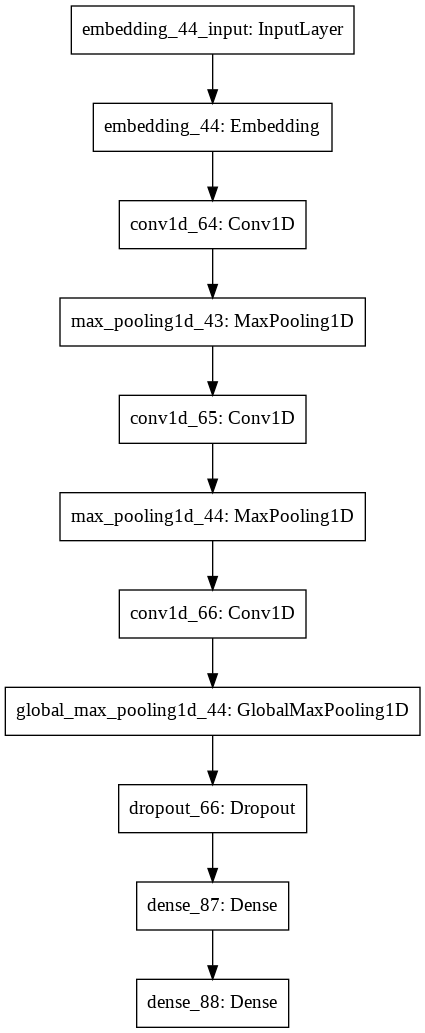

In [496]:
plot_model(model_cnn, to_file='multiclass-cnn.png')

In [ ]:
# Decomment following line if you want to download model figure
# files.download('multiclass-cnn.png')